In [3]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import joblib

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/698/10step_5horizon/data")
df_rf_15 = pd.read_csv('df_rf_15.csv')
df_rf_20 = pd.read_csv('df_rf_20.csv')
df_rf_25 = pd.read_csv('df_rf_25.csv')
df_rf_30 = pd.read_csv('df_rf_30.csv')
df_rf_35 = pd.read_csv('df_rf_35.csv')
df_rf_40 = pd.read_csv('df_rf_40.csv')
df_rf_45 = pd.read_csv('df_rf_45.csv')
heroes= pd.read_csv('heroes.csv')
heroes = heroes.rename(columns = {'id':'hero_id'})
df2_allhero = pd.read_csv('df2_allhero.csv') # We use this to instantiate the embedding layer since thats how the embedding layers were created and i want to avoid any shenanigans like the hero_ids and their indexes getting jumbled due to ordering when they get mapped by hero_id_to_idx

Split RF Structures for Model Training

In [2]:
def split_data(df, test_size):
  X = df.drop('winner', axis=1)
  y = df['winner']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

  return X_train, X_test, y_train, y_test

def drop_columns(df):
  cols_to_drop = df.filter(regex=r'\d_gold$|rad_pos\d$|dire_pos\d$|minute|match_id$').columns
  df = df.drop(columns= cols_to_drop)
  return df




Train Test Split across all dataframes

RF_15:        Acc      Prec   Recall        F1

0  0.73913  0.740192  0.73913  0.738462


RF_20:         Acc      Prec    Recall        F1

0  0.778547  0.778632  0.778547  0.778552


RF_25:         Acc     Prec    Recall        F1

0  0.775591  0.77581  0.775591  0.775399

RF_30:         Acc      Prec    Recall        F1

0  0.776119  0.776199  0.776119  0.775986

RF_35:         Acc      Prec    Recall        F1

0  0.755396  0.755046  0.755396  0.755064

RF_40:         Acc     Prec    Recall        F1

0  0.776471  0.78542  0.776471  0.775602

RF_45:         Acc     Prec    Recall        F1

0  0.666667  0.67004  0.666667  0.668027

Build RandomForest Classifiers Across all dataframes

#### No CCP Alpha
Accuracy: 0.7324
Precision: 0.7324
Recall: 0.7324
F1-score: 0.7324

#### CCP Alpha .01
Accuracy: 0.7391
Precision: 0.7402
Recall: 0.7391
F1-score: 0.7385.

In [10]:
def create_save_plots(rf_classifier_name, X_test_name, y_test_name, df,file_name):
  from sklearn.tree import plot_tree
  #RF_No_Predict_No_Embed
  os.chdir("/content/drive/MyDrive/Colab Notebooks/698/10step_5horizon/plots/no_embed_rf")
  # Evaluate each tree in the random forest classifier
  tree_accuracies = []

  y_test_name = y_test_name.replace({'dire': 0, 'radiant': 1})

  for tree in rf_classifier_name.estimators_:
      y_pred_tree = tree.predict(X_test_name)
      accuracy_tree = accuracy_score(y_test_name, y_pred_tree)
      tree_accuracies.append(accuracy_tree)

  # Find the index of the tree with the highest accuracy
  best_tree_index = np.argmax(tree_accuracies)
  best_tree = rf_classifier_name.estimators_[best_tree_index]
  best_tree_accuracy = tree_accuracies[best_tree_index]

  # Plot a decision tree from the random forest
  plt.figure(figsize=(12, 8))
  plt.title(f"Best Tree: {best_tree_accuracy}\n Acc: {best_tree_accuracy}")
  plot_tree(best_tree, filled=True, rounded=True, feature_names=df.columns[:-1])
  plt.savefig(f'{file_name}_Best_Tree.png')
  plt.show()

  # Plot feature importances
  importances = rf_classifier_name.feature_importances_
  indices = np.argsort(importances)[::-1]
  feature_names = df.columns[:-1]
  #print(importances)
  #print(feature_names)

  plt.figure(figsize=(10, 6))
  plt.title(f"Feature Importances")
  plt.bar(range(len(feature_names)), importances[indices])
  plt.xticks(range(len(feature_names)), [feature_names[i] for i in indices], rotation=45)
  plt.tight_layout()
  plt.savefig(f'{file_name}_Tree_Importances.png')
  plt.show()

  os.chdir("/content/drive/MyDrive/Colab Notebooks/698/10step_5horizon/models/no_embed_rf")

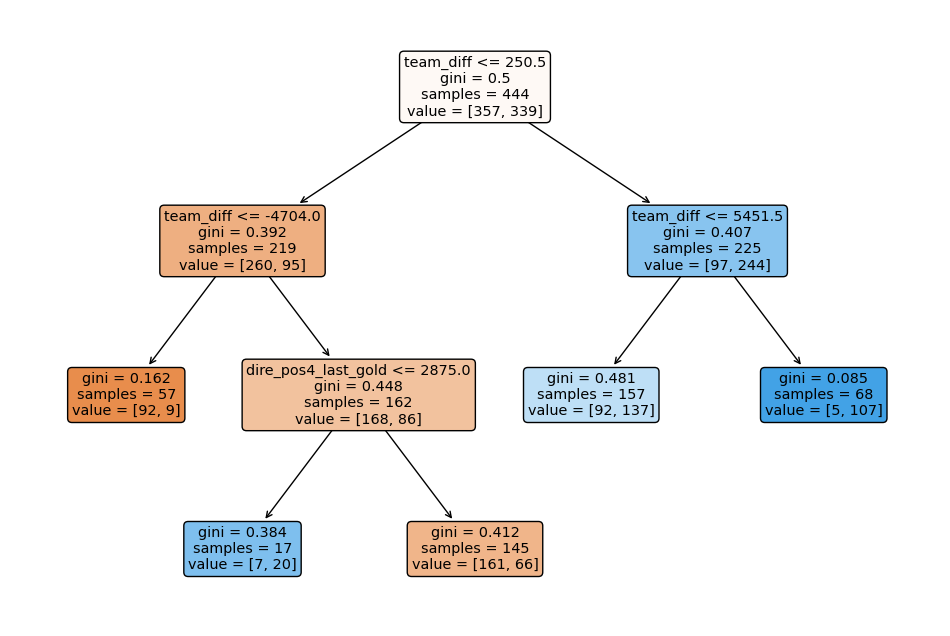

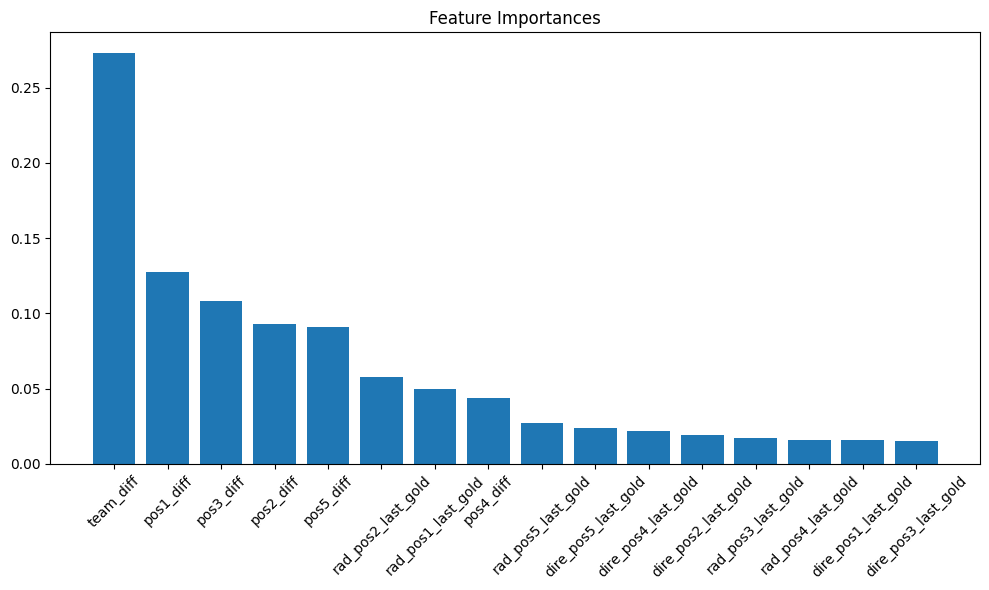

RF_15:        Acc      Prec   Recall        F1
0  0.73913  0.740192  0.73913  0.738462


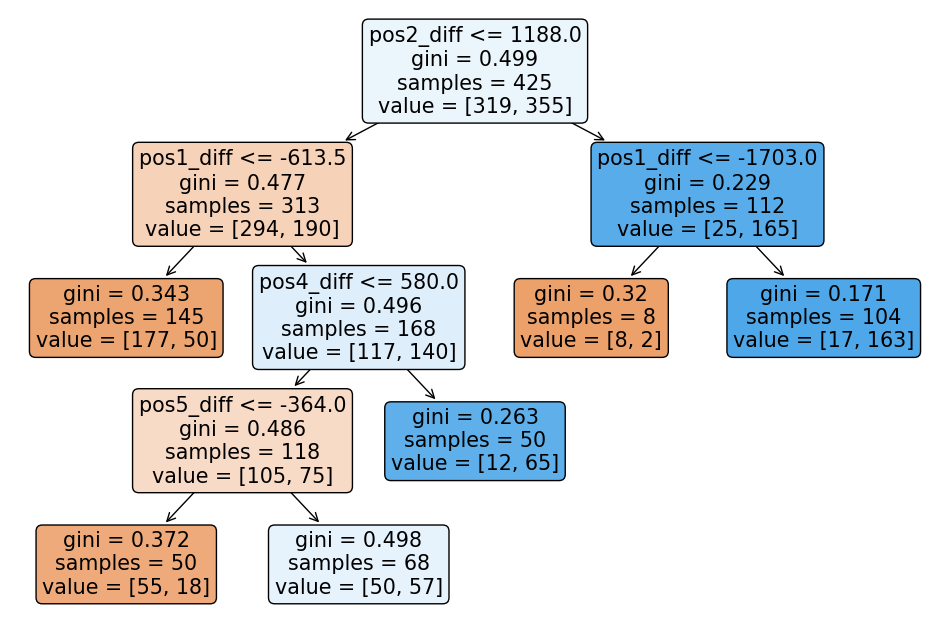

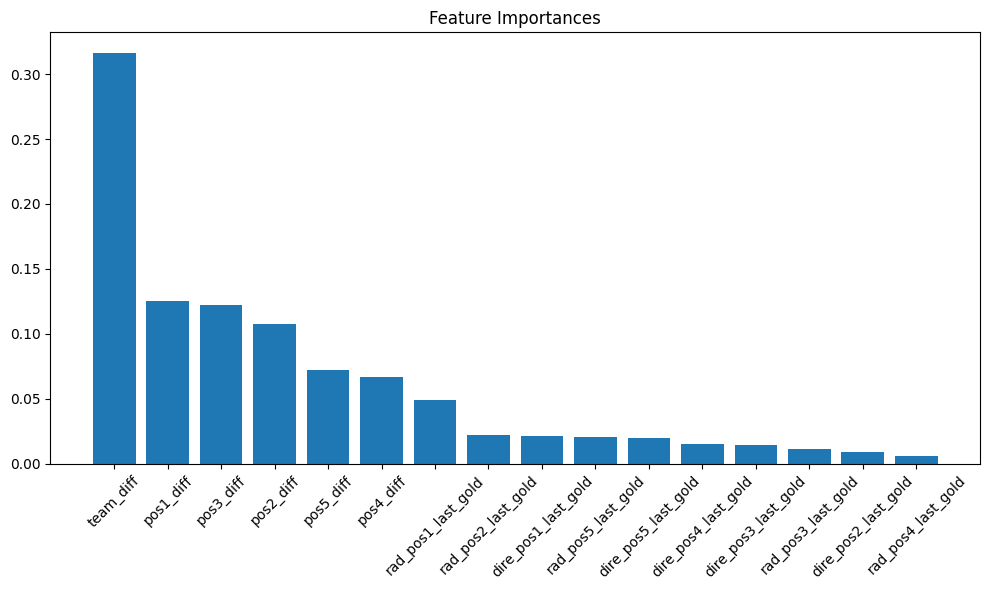

RF_20:         Acc      Prec    Recall        F1
0  0.778547  0.778632  0.778547  0.778552


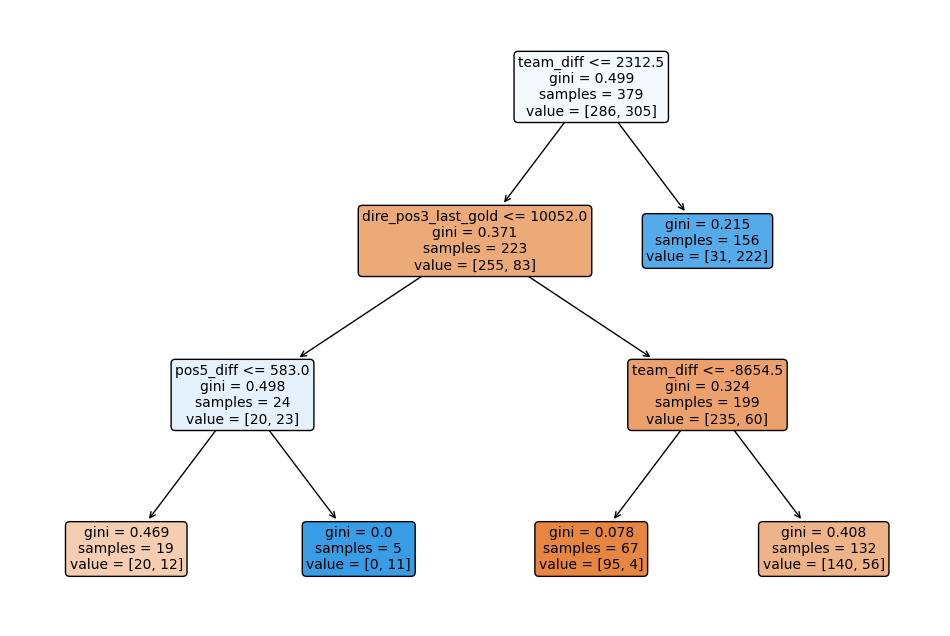

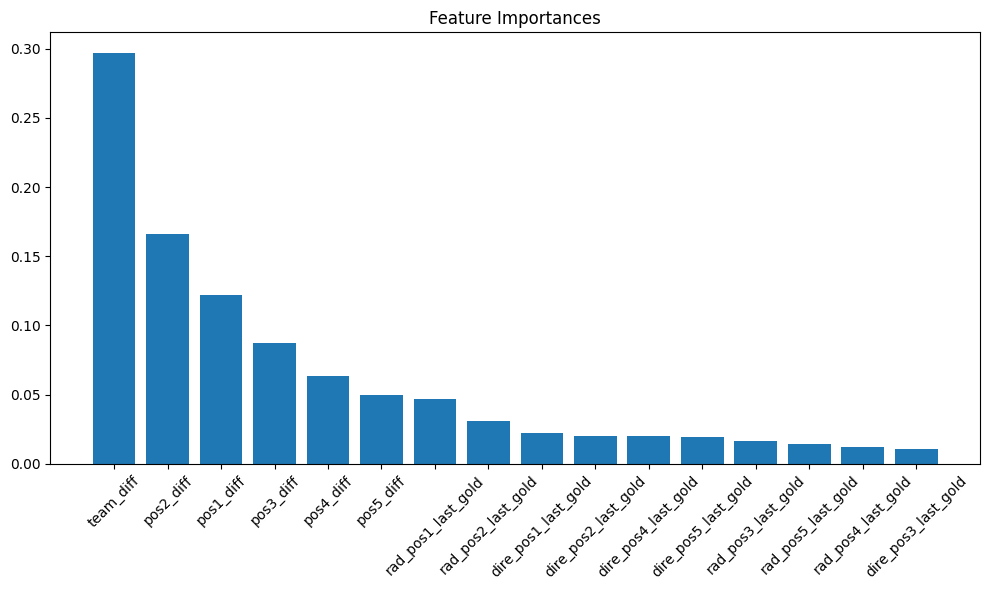

RF_25:         Acc     Prec    Recall        F1
0  0.775591  0.77581  0.775591  0.775399


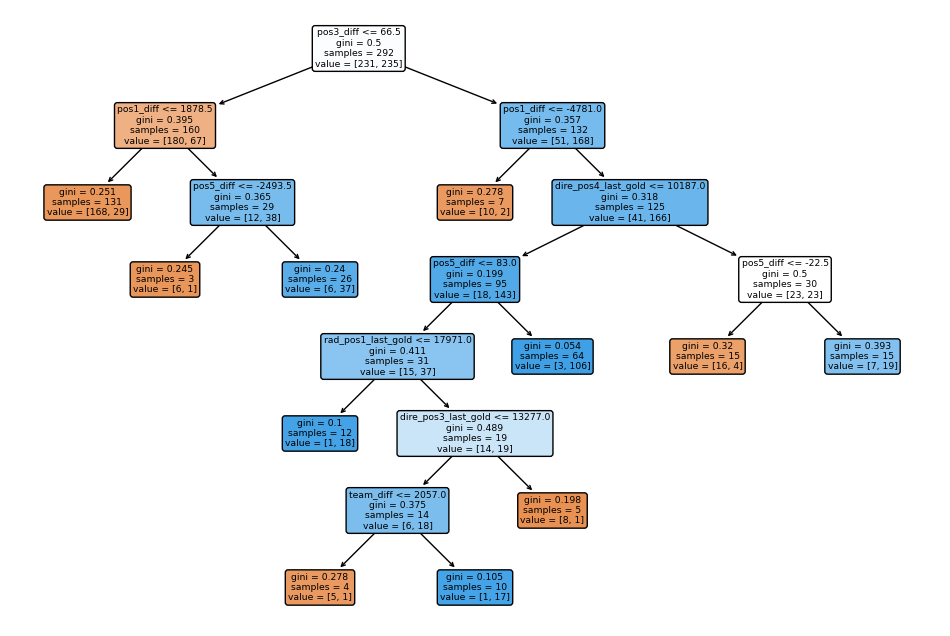

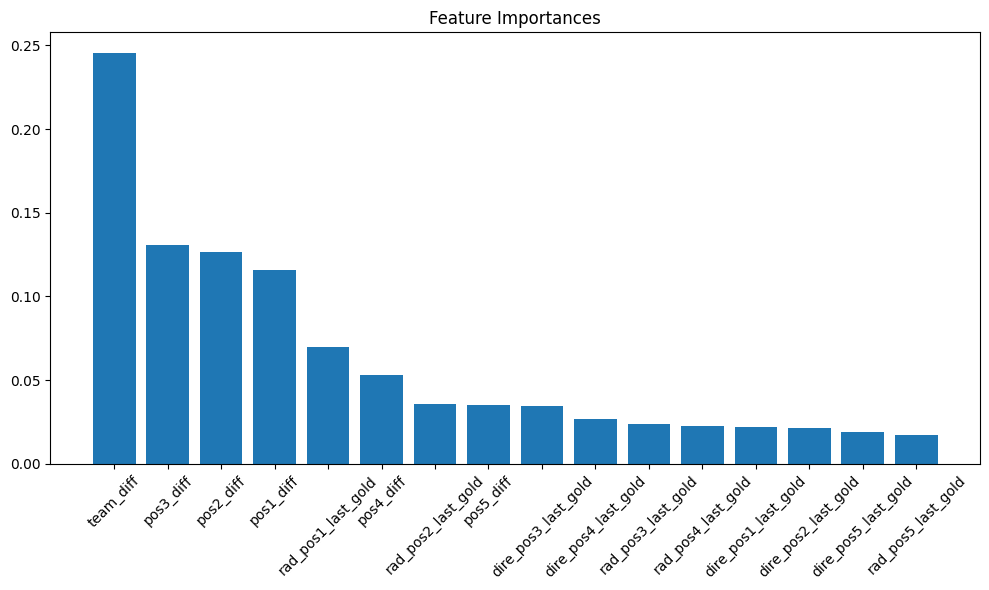

RF_30:         Acc      Prec    Recall        F1
0  0.776119  0.776199  0.776119  0.775986


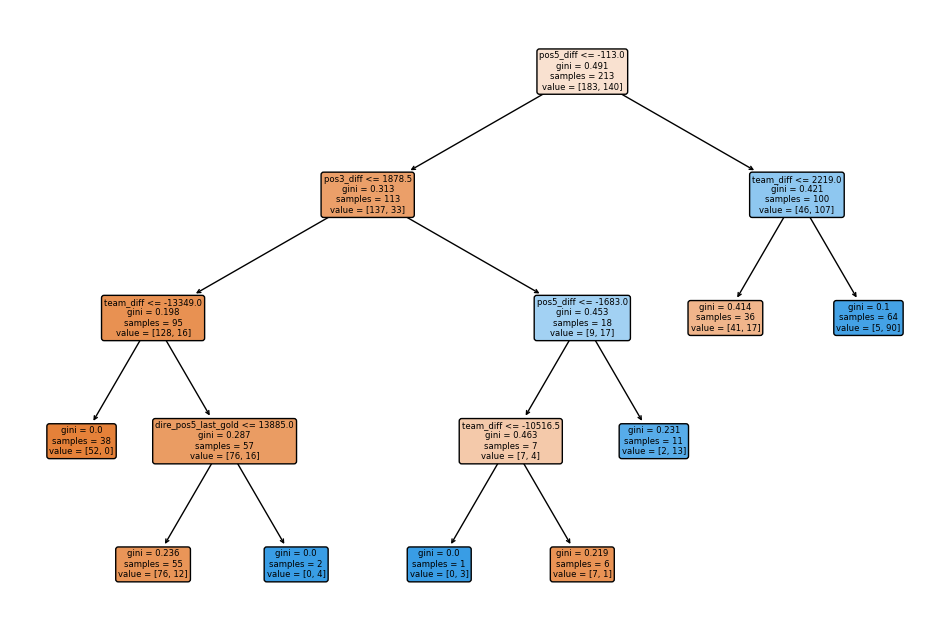

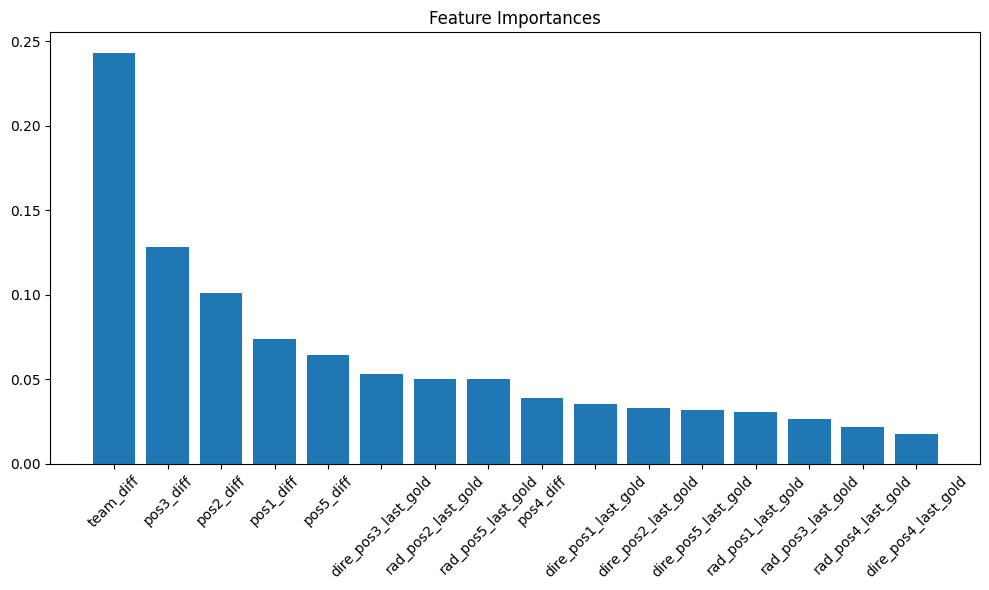

RF_35:         Acc      Prec    Recall        F1
0  0.755396  0.755046  0.755396  0.755064


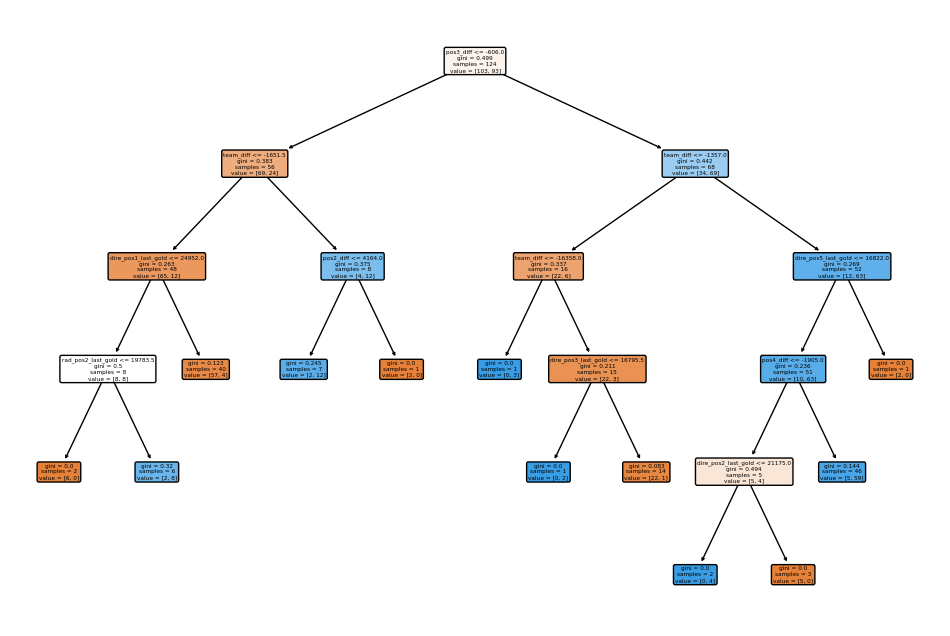

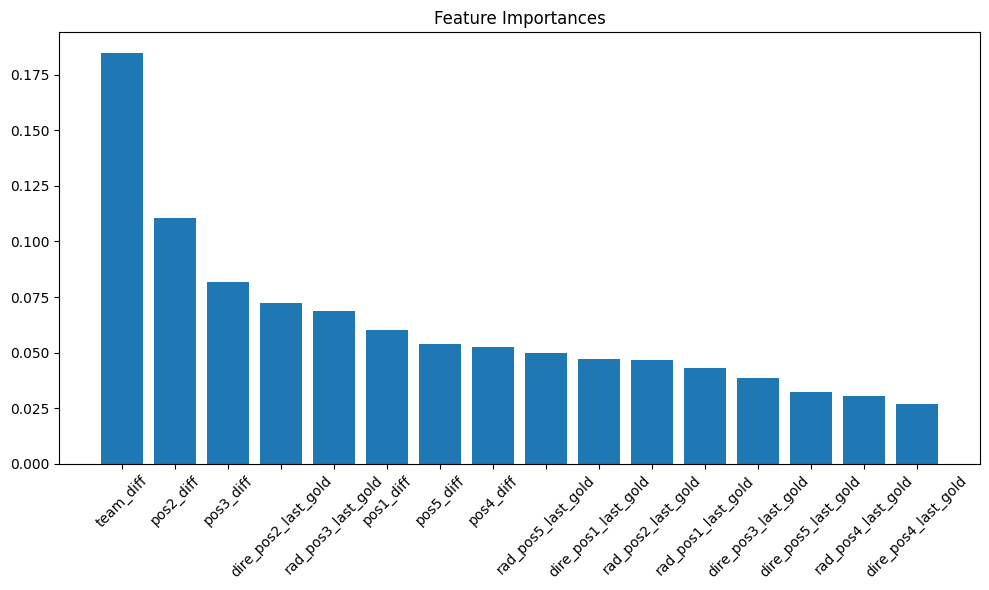

RF_40:         Acc     Prec    Recall        F1
0  0.776471  0.78542  0.776471  0.775602


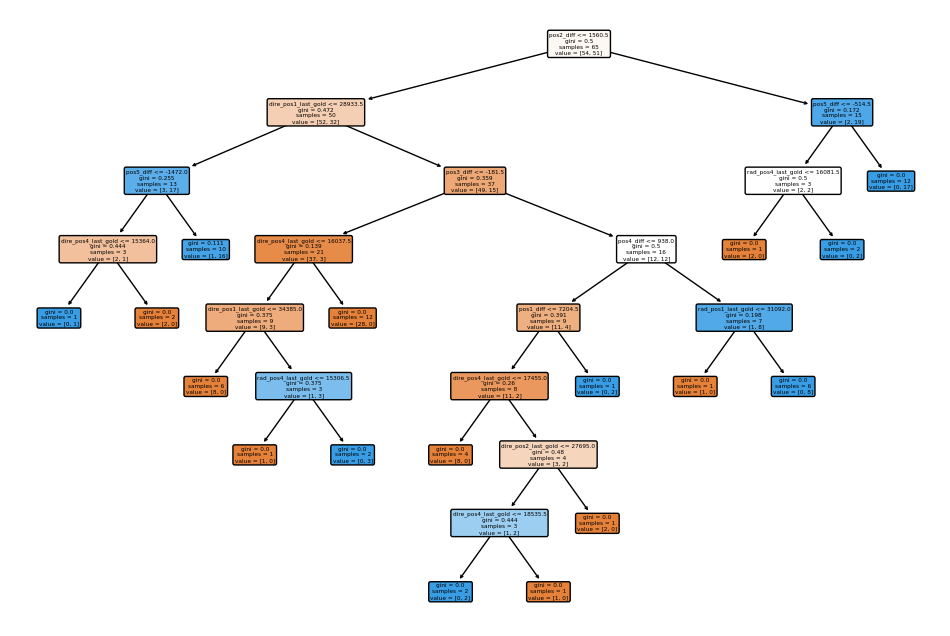

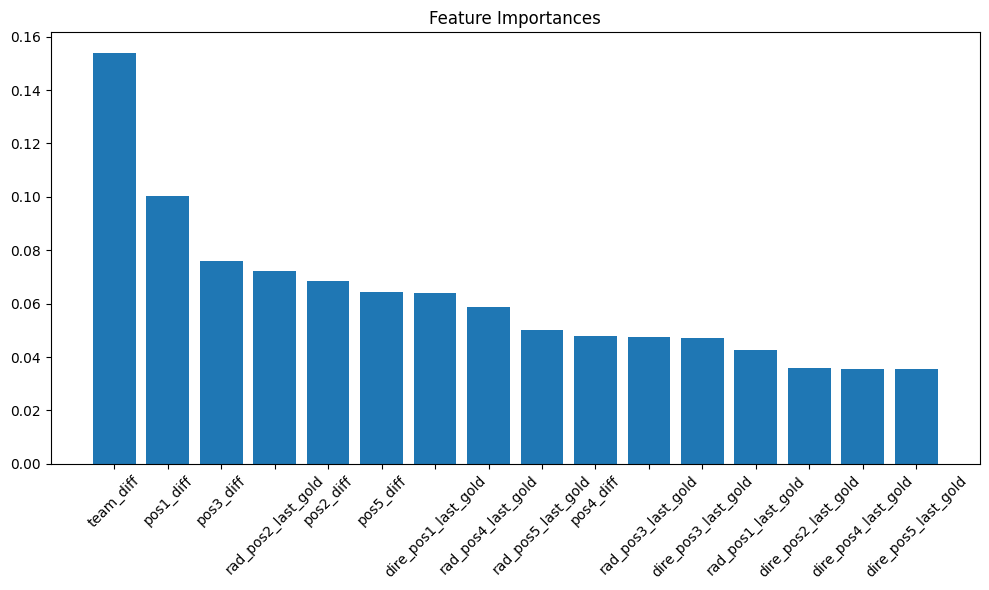

RF_45:         Acc     Prec    Recall        F1
0  0.666667  0.67004  0.666667  0.668027


In [11]:
import warnings

warnings.filterwarnings('ignore')
os.chdir("/content/drive/MyDrive/Colab Notebooks/698/10step_5horizon/models/no_embed_rf")
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, ccp_alpha=0.01)

for i in range(15, 50, 5): # range does not include the last value i.e. 50 wont be included
    df_name = f'df_rf_{i}'
    X_train_name = f'rf_{i}_X_train'
    X_test_name = f'rf_{i}_X_test'
    y_train_name = f'rf_{i}_y_train'
    y_test_name = f'rf_{i}_y_test'
    test_size = .30

    rf_class_name = f'rf_classifier_{i}'
    y_pred_name = f'y_pred_{i}'
    acc_name = f'acc_{i}'
    prec_name= f'prec_{i}'
    recall_name = f'recall_{i}'
    f1_name = f'f1_{i}'

    df_metrics_name = f'df_metrics_{i}'
    iteration = i

    #file_name = f'rf_{i}_no_embed'


    exec(f"{df_name} = drop_columns({df_name})")
    exec(f"{X_train_name}, {X_test_name}, {y_train_name}, {y_test_name} = split_data({df_name},{test_size})")

    # Saving indexes to be tested on with predicted values
    exec(f"os.chdir('/content/drive/MyDrive/Colab Notebooks/698/10step_5horizon/data/test_data/no_embed')")
    exec(f"rf_noemb_y_test_index_{i} = {y_test_name}.index")
    exec(f"np.save('rf_noemb_y_test_index_{i}.npy', rf_noemb_y_test_index_{i})")


    exec(f"{rf_class_name} = rf_classifier.fit({X_train_name}, {y_train_name})")
    exec(f"joblib.dump({rf_class_name}, '{rf_class_name}.pkl')")
    exec(f"{y_pred_name} = {rf_class_name}.predict({X_test_name})")
    exec(f"{acc_name} = accuracy_score({y_test_name},{y_pred_name})")
    exec(f"{prec_name} = precision_score({y_test_name}, {y_pred_name}, average='weighted')")
    exec(f"{recall_name} = recall_score({y_test_name}, {y_pred_name}, average='weighted')")
    exec(f"{f1_name} = f1_score({y_test_name}, {y_pred_name}, average='weighted')")


    exec(f"create_save_plots({rf_class_name},{X_test_name},{y_test_name},{df_name},{iteration})")
    #rf_classifier_name, X_test_name, y_test_name, y_pred_name, df,file_name

    exec(f"{df_metrics_name} = pd.DataFrame([[{acc_name},{prec_name},{recall_name},{f1_name}]], columns =['Acc','Prec','Recall','F1'] )")
    exec(f"{df_metrics_name}.to_csv('RF_{i}_metrics.csv')")
    exec(f"print('RF_{i}:',{df_metrics_name})")

XGBoost

In [6]:
def plot_xgb_tree(best_model,file_name):
  from xgboost import plot_tree
  fig, ax = plt.subplots(figsize=(18, 14))  # Adjust the figsize as needed

# Plot the tree
  plot_tree(best_model, ax=ax)

  # Optionally, you can customize other aspects of the plot
  ax.set_title("XGBoost Decision Tree")
  ax.set_xlabel("Feature")
  ax.set_ylabel("Value")

  # plt.figure(figsize=(10, 6))
  # plt.title(f"XGB Best Decision Tree")
  # plot_tree(best_model)
  plt.savefig(f'{file_name}_Best_Tree.png')
  plt.show()

In [7]:
from xgboost import XGBClassifier
from xgboost import plot_tree
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [200, 300],
    'max_depth':  [10],
    'learning_rate': [0.01], #,0.1],
    'subsample': [0.8], #,1.0],
    'colsample_bytree': [0.8], #, 1.0],
    'gamma': [0, 0.1, 0.3],
    'min_child_weight': [1, 5, 10]
}

dataframes = [df_rf_15, df_rf_20, df_rf_25, df_rf_30, df_rf_35, df_rf_40, df_rf_45]
iterations = [15, 20, 25, 30, 35, 40, 45]

for df, iteration in zip(dataframes, iterations):
    df_dropped = drop_columns(df)
    X_train, X_test, y_train, y_test = split_data(df_dropped, test_size=.30)

    # Saving Indexes of test data
    os.chdir("/content/drive/MyDrive/Colab Notebooks/698/10step_5horizon/data/test_data/no_embed")
    xg_y_test_index = y_test.index
    np.save(f'xg_noemb_y_test_index_{iteration}.npy', xg_y_test_index)

    y_train_binary = y_train.replace({'dire': 0, 'radiant': 1})
    label_mapping = {'dire': 0, 'radiant': 1}
    label_mapper = np.vectorize(lambda x: label_mapping[x])

    y_test_binary = y_test.replace({'dire': 0, 'radiant': 1})

    # Create an instance of XGBClassifier
    xgbclass = XGBClassifier(random_state=42)

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(estimator=xgbclass, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train_binary)

    # Get the best model
    best_model = grid_search.best_estimator_

    # Save that son of a gun
    os.chdir("/content/drive/MyDrive/Colab Notebooks/698/10step_5horizon/models/no_embed_xgb")
    joblib.dump(best_model, f'XGB_no_embed_{iteration}_model.pkl')

    # Make predictions on the test set using the best model
    y_pred = best_model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test_binary, y_pred)
    precision = precision_score(y_test_binary, y_pred, average='weighted')
    recall = recall_score(y_test_binary, y_pred, average='weighted')
    f1 = f1_score(y_test_binary, y_pred, average='weighted')

    print(f"Best parameters for iteration {iteration}: {grid_search.best_params_}")
    print(f"Accuracy for iteration {iteration}: {accuracy:.4f}")
    print(f"Precision for iteration {iteration}: {precision:.4f}")
    print(f"Recall for iteration {iteration}: {recall:.4f}")
    print(f"F1-score for iteration {iteration}: {f1:.4f}")

    os.chdir("/content/drive/MyDrive/Colab Notebooks/698/10step_5horizon/models/no_embed_xgb")
    XGB_metrics = pd.DataFrame([[accuracy, precision, recall, f1]], columns=['Acc', 'Prec', 'Recall', 'F1'])
    XGB_metrics.to_csv(f'XGB_no_embed_{iteration}_metrics.csv')
    print(f"XGB_metrics for iteration {iteration}:\n{XGB_metrics}")

    os.chdir("/content/drive/MyDrive/Colab Notebooks/698/10step_5horizon/plots/no_embed_xgb")
    plot_xgb_tree(best_model, f'XGB_no_embed_{iteration}')

    feature_importances = best_model.feature_importances_
    feature_names = X_train.columns
    sorted_idx = feature_importances.argsort()[::-1]
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(feature_importances)), feature_importances[sorted_idx])
    plt.xticks(range(len(feature_importances)), feature_names[sorted_idx], rotation=45, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title(f'Feature Importance (Iteration {iteration})')
    plt.tight_layout()
    plt.savefig(f"/content/drive/MyDrive/Colab Notebooks/698/10step_5horizon/plots/embed_xgb/XGB_{iteration}_feature_importance.png")
    plt.show()

Output hidden; open in https://colab.research.google.com to view.